<h1>Figure 2</h1>
<p>Data used for this figure are saved in the following files:</p>

<table>
    <tr>
        <th></th>
        <th></th>
    </tr>
    <tr>
        <td><a href="110912_copy_no_qPCR.csv" target=_blank>110912_copy_no_qPCR.csv</a></td>
        <td>qPCR-derived Ct data on plasmid copy numbers.</td>
    </tr>
    <tr>
        <td><a href="110818_2u_CFlucs_Growth.csv" target=_blank>110818_2u_CFlucs_Growth.csv</a></td>
        <td>Growth data of yeast containing the different luciferase variant 2&mu; plasmids</td>
    </tr>
    <tr>
        <td><a href="111012 Death Rates.csv" target=_blank>111012 Death Rates.csv</a></td>
        <td>Life/ dead cell counts of yeast containing the different luciferase variant 2&mu; plasmids</td>
    </tr>
</table>


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
%run qPCR.py

<h2>Plasmid copy number</h2>

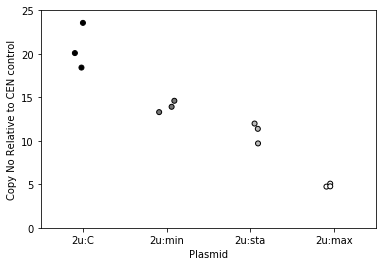

In [2]:
#read in an process qPCR data using the process_qPCR fucntion from file qPCR.py
qPCR_data = process_qPCR('110912_copy_no_qPCR.csv')
#plot data 
sns.set_palette(['#000000','#777777','#bbbbbb','#ffffff'])
sns.stripplot(x='Plasmid',y='fold_change_CEN',data=qPCR_data, 
              jitter=True, 
              order=['2u:C','2u:min','2u:sta','2u:max'],
             edgecolor = '#000000',linewidth=1)
plt.ylabel('Copy No Relative to CEN control')
plt.xlabel('Plasmid')
plt.ylim(0,25)
#plt.savefig('Figure 2a.svg')
plt.show()

In [3]:
#do statistics for comparisons with 2u:C
alphas = [0.05,0.01,0.001]

#if stats_results is alrady present in locals, delete it
if 'stats_results' in locals():
    del stats_results

#do the statistical tests for each level defined in alphas
for alpha in alphas:
    #do the actual test at this level
    mc = MultiComparison(qPCR_data['fold_change_CEN'], qPCR_data['Plasmid'])
    result = mc.tukeyhsd(alpha=alpha)
    #recover the results into a data frame and rename the columns
    result_frame = pd.DataFrame(data=result._results_table.data[1:], columns=result._results_table.data[0])
    result_frame = result_frame.loc[result_frame['group1'] == '2u:C'].iloc[:,[1,5]]
    newcolname = "p = " + str(alpha)
    result_frame = result_frame.rename(index=str, columns={"group2":'Plasmid',"reject": newcolname})
    #add the results at this level to stats_results
    if 'stats_results' in locals():
        stats_results = pd.merge(stats_results, result_frame,on='Plasmid')
    else:
        stats_results=result_frame

stats_results = stats_results.set_index('Plasmid')
print(stats_results.reindex(['2u:min','2u:sta','2u:max']))

         p = 0.05  p = 0.01  p = 0.001
Plasmid                               
2u:min       True      True      False
2u:sta       True      True       True
2u:max       True      True       True


<h2>Growth rate</h2>

In [4]:
raw_data = pd.read_csv('110818_2u_CFlucs_Growth.csv')
#extract the actual data and the factors from raw_data in the order of the growth data table
data = np.array(raw_data.iloc[6:,3:]).astype(float)
factors = list(raw_data.iloc[6:,0])

#generate matching x-values based on samples being taken every 30 minutes starting from 0
x= np.linspace(0,(data.shape[1]-1)/2, num=data.shape[1])

#define the curve fitting function
def func(x, a, b):
    return a * np.exp(b * x)

#process windows of size window_size along the x-axis. For each window, fit data to the curve
# and record the second parameter
exponents = []
window_size = 7

#process all samples (rows)
for row in range(data.shape[0]):
    this_parameter_array = np.zeros([1,data.shape[1]+10], dtype=float)
    window_start = 1
    while window_start < (data.shape[1] - (window_size + 1)):
        xdata = x[window_start:(window_start+window_size)]
        ydata = data[row,window_start:(window_start+window_size)]
        popt, pcov = curve_fit(func, xdata, ydata)
        this_parameter_array[:,window_start] = popt[1]
        window_start = window_start + 1

    exponents.append(this_parameter_array.max())
    
#normalise exponents to control
exponents = np.array(exponents)
controls = [i for i, j in enumerate(factors) if j == '2u:C']
exponents = exponents / np.mean(exponents[controls])

rel_growth = pd.DataFrame({'Plasmid':factors,'Rel_GR':exponents})

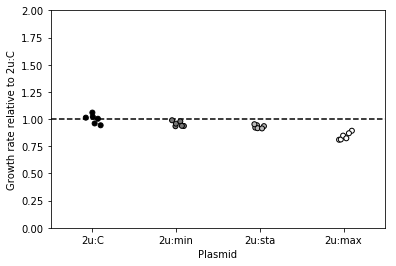

In [5]:
sns.set_palette(['#000000','#777777','#bbbbbb','#ffffff'])
sns.stripplot(x='Plasmid',y='Rel_GR',data=rel_growth,jitter=True,
             edgecolor = '#000000',linewidth=1)
plt.ylabel('Growth rate relative to 2u:C')
plt.xlabel('Plasmid')
plt.ylim(0,2)
plt.axhline(1, ls='dashed')
#plt.savefig('Figure 2b.svg')
plt.show()

In [6]:
#do statistics for comparisons with 2u:C
alphas = [0.05,0.01,0.001]

#if stats_results is alrady present in locals, delete it
if 'stats_results' in locals():
    del stats_results

#do the statistical tests for each level defined in alphas
for alpha in alphas:
    #do the actual test at this level
    mc = MultiComparison(rel_growth['Rel_GR'], rel_growth['Plasmid'])
    result = mc.tukeyhsd(alpha=alpha)
    #recover the results into a data frame and rename the columns
    result_frame = pd.DataFrame(data=result._results_table.data[1:], columns=result._results_table.data[0])
    result_frame = result_frame.loc[result_frame['group1'] == '2u:C'].iloc[:,[1,5]]
    newcolname = "p = " + str(alpha)
    result_frame = result_frame.rename(index=str, columns={"group2":'Plasmid',"reject": newcolname})
    #add the results at this level to stats_results
    if 'stats_results' in locals():
        stats_results = pd.merge(stats_results, result_frame,on='Plasmid')
    else:
        stats_results=result_frame

stats_results = stats_results.set_index('Plasmid')
print(stats_results.reindex(['2u:min','2u:sta','2u:max']))

         p = 0.05  p = 0.01  p = 0.001
Plasmid                               
2u:min      False     False      False
2u:sta       True      True      False
2u:max       True      True       True


In [8]:
print(rel_growth.groupby('Plasmid').mean())

           Rel_GR
Plasmid          
2u:C     1.000000
2u:max   0.842699
2u:min   0.955868
2u:sta   0.930603
